# Clustering NBA Players: A Machine Learning Tutorial on using KMeans Clustering

In this blog post, I am sharing my experience in understanding and employing K-Means clustering by clustering NBA Players. K-Means is a popular centroid-based clustering algorithm that we will use. The K in K-Means refers to the number of clusters we want to segment our data into. We first load the dataset of player performance from the 2013-2014 season which has columns such as 'name of the player', 'their position', 'number of games played' etc. In particular we are interested in clustering point guards based on their match statistics. 


Point guards play one of the most crucial roles on a team because their primary responsibility is to create scoring opportunities for the team. We visualize the types of point guards as well as group similar point guards together using K-Means clustering. Using 2 features allows us to easily visualize the players and will also make it easier to grasp how clustering works. For point guards, it's widely accepted that the Assist to Turnover Ratio is a good indicator for performance in games as it quantifies the number of scoring opportunities that player created. Let's also use Points Per Game, since effective Point Guards not only set up scoring opportunities but also take a lot of the shots themselves. 

[Check out Database Basketball for an explanation of all the columns](https://www.rotowire.com/)

[View the dataquest project here](https://www.dataquest.io/m/40/k-means-clustering)

![](https://i.ytimg.com/vi/ey0sj5qkPJQ/maxresdefault.jpg)

My project has following parts
* [Understanding the data](#load-and-understand-data)
* [Feature engineering](#feature-engineering)
* [K-Means Clustering Algorithm from Scratch](#k-means-clustering-algorithm-from-scratch)
* [K-Means Clustering with Scikit Learn](#k-means-clustering-with-scikit-learn)

## Understanding the data

Some of the columns in the dataset are:

- player -- name of the player
- pos -- the position of the player
- g -- number of games the player was in
- pts -- total points the player scored
- fg. -- field goal percentage
- ft. -- free throw percenta

In [80]:
import pandas as pd
import numpy as np

nba = pd.read_csv("nba_2013.csv")
nba.head(3)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013


### Pointguards 
We do the following to extract information on the pointguards:

- Create a new Dataframe which contains just the point guards (specified as PG in the pos column) from the data set.
- Assign the filtered data frame to point_guards.

In [81]:
# Extracting pointguards from dataframe
point_guards = nba[nba['pos']=='PG']

## Feature Engineering

While our dataset doesn't come with Points Per Game, **ppg** values, we can easily calculate those using each player's total points (pts) and the number of games (g) they played. Similarly we can create a column, **atr**, for the Assist Turnover Ratio, which is calculated by dividing total assists (ast) by total turnovers (tov).

1. Create a feature called ppg (points per game)
2. Drop any player with zero value of turnover and create a feature called atr (Assist Turnover Ratio) 

In [82]:
# Create a feature called ppg, points per game
point_guards['ppg'] = point_guards['pts'] / point_guards['g']

# Drop any player with zero value of turnover 
point_guards = point_guards[point_guards['tov'] != 0]

# Create a feature called atr (Assist Turnover Ratio)
point_guards['atr'] = point_guards['ast']/point_guards['tov']

# remove the remaining columns
point_guards = point_guards[['pts', 'g', 'ppg', 'ast', 'tov', 'atr']]

# Sanity check, make sure ppg = pts/g and atr = ast/tov
# point_guards.head(2)

/Users/suruchi/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [83]:
# Display figures in ceter
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

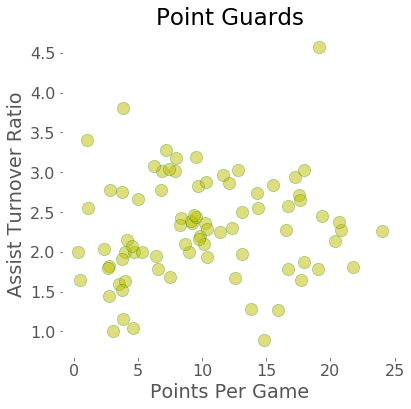

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline 
import re
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})

# Visualize the cluster
fig = plt.figure(num=None, figsize=(6, 6), edgecolor='k')

ax = fig.add_subplot(1, 1, 1, facecolor="1.0")
ax.scatter(point_guards['ppg'], point_guards['atr'], alpha=0.5, c='y', edgecolors='g', s=150)
plt.title("Point Guards")
plt.xlabel('Points Per Game')
plt.ylabel('Assist Turnover Ratio')
plt.show()

There already seems to be some clustering in the data, with three clusters fairly prominant. We can see how 4 or 5 clusters would be a good starting point for these features.

## K-Means Clustering Algorithm From Scratch

K-Means is a popular centroid-based clustering algorithm that we will use. The K in K-Means refers to the number of clusters we want to segment our data into. The key part with K-Means (and most unsupervised machine learning techniques) is that we have to specify what k is. There are advantages and disadvantages to this, but one advantage is that we can pick the k that makes the most sense for our use case. We'll set k to 5 based on the scatter plot above.


Setup K-Means is an iterative algorithm that switches between recalculating the centroid of each cluster and the players that belong to that cluster. The algorithm to clustering goes as follows:

**Step 1: Select K=5 players at random and assign their coordinates as the initial centroids of the just created clusters. **

**Step 2: For each player, calculate the Euclidean distance between that player's coordinates, or values for x=atr & y=ppg, and each of the centroids' coordinates.**

**Step 3: Assign the player to the cluster whose centroid is the closest to, or has the lowest Euclidean distance to, the player's values.**

**Step 4: For each cluster, compute the new centroid by calculating the arithmetic mean of all of the points (players) in that cluster. Calculate the arithmetic mean by taking the average of all of the X-values (atr) and the average of all of the Y-values (ppg) of the points in that cluster.**

**Step 5: Iterate Repeat steps 2 through 4 until the clusters are no longer moving and have converged.**


### Step 1:  Initial Centroids

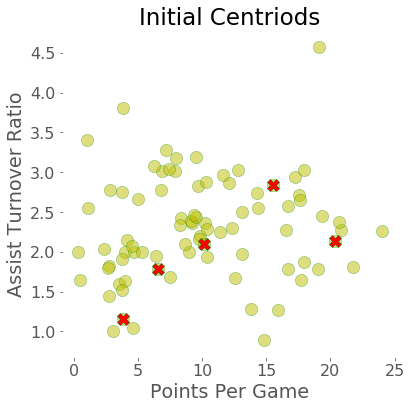

In [85]:
# Step 1: Create a random cluster and Visualize it

num_clusters = 5
# Use numpy's random function to generate a list, length: num_clusters, of indices
random_initial_points = np.random.choice(point_guards.index, size=num_clusters)
# Use the random indices to create the centroids
centroids = point_guards.loc[random_initial_points]

# Visualize the cluster
fig = plt.figure(num=None, figsize=(6, 6), edgecolor='k')

ax = fig.add_subplot(1, 1, 1, facecolor="1.0")

ax.scatter(point_guards['ppg'], point_guards['atr'], alpha=0.5, c='y', edgecolors='g', s=150)
ax.scatter(centroids['ppg'], centroids['atr'], alpha=1, c='r', edgecolors='g', s=150, marker='X')

plt.title("Initial Centriods")
plt.xlabel('Points Per Game')
plt.ylabel('Assist Turnover Ratio')
plt.show()


As we can see the clusters are just subsets of players positions on the scatter plot and we now need to iteratively evolve the location of these clusters. One way to keep track of the clusters as the move as per iterations in by storing them in python dictionary like objects as follows:

- key: cluster_id of that centroid's cluster (0 through 4)
- value: centroid's coordinates expressed as a list ( ppg value first, atr value second ) 

We'll write a function, __centroids_to_dict__, that takes in the centroids data frame object, creates a cluster_id and converts the ppg and atr values for that centroid into a list of coordinates, and adds both the cluster_id and coordinates_list into the dictionary that's returned

In [86]:
def centroids_to_dict(centroids):
    dictionary = dict()
    # iterating counter we use to generate a cluster_id
    counter = 0

    # iterate a pandas data frame row-wise using .iterrows()
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)

## Step 2: Euclidean Distance

Before we can assign players to clusters, we need a way to compare the 'ppg' and 'atr' values of each player with each cluster's centroids. Euclidean distance is the most common technique used in data science for measuring distance between vectors and works extremely well in 2 and 3 dimensions. In 2 dimensions Euclidean distance is essentially the Pythagorean theorem.

Let's create the function __calculate_distance__, which takes in 2 lists (the player's values for ppg and atr and the centroid's values for ppg and atr).



In [87]:
"""
Function takes player's values for ppg and atr in a list 
and centroid's values for ppg and atr in another list
and returns the euclid_distance
"""
import math

def calculate_distance(centroid, player_values):
    root_distance = 0
    
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference

    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

# test
print(calculate_distance([0, 0], [3,4]))

5.0



### Step 3: Assign Players to Cluster

For each player, we want to calculate the distances to each cluster's centroid using euclidean_distance.
Once we know the distances, we can determine which centroid is the closest (has the lowest distance) and return that centroid's cluster_id

In [88]:
# Add the function, `assign_to_cluster`
# This creates the column, `cluster`, by applying assign_to_cluster row-by-row

def assign_to_cluster(row):
    
    player_vals = [row['ppg'], row['atr']]
    dist_prev = -1
    cluster_id = None
    
    for centroid_id, centroid_vals in centroids_dict.items():
        dist = calculate_distance(centroid_vals, player_vals)
        if dist_prev == -1 :
            cluster_id = centroid_id 
            dist_prev = dist
        elif dist < dist_prev :
            cluster_id = centroid_id
            dist_prev = dist
    return cluster_id

# Apply to each row in point_guards
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)

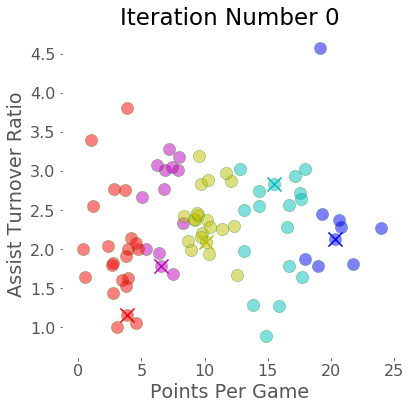

In [89]:
# Visualizing clusters

def visualize_clusters(df, num_clusters, iteration):
    colors = ['b', 'y', 'r', 'c', 'y', 'm']
    fig = plt.figure(num=None, figsize=(6, 6), edgecolor='k')
    ax = fig.add_subplot(1, 1, 1, facecolor="1.0")
    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        ax.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1], edgecolors='g', alpha=0.5, s=150)
        ax.scatter(centroids_dict[n][0], centroids_dict[n][1], alpha=1, c=colors[n-1], edgecolors='b', s=200, marker='x')
        plt.xlabel('Points Per Game')
        plt.ylabel('Assist Turnover Ratio')
        plt.title('Iteration Number %s'%(iteration))
    plt.show()
iteration=0
visualize_clusters(point_guards, 5, iteration)

### Step 4: Update the Centroids

Here we calculate the arithmetic mean of all of the points (players) in that cluster by taking the average of all of the X-values (atr) and the average of all of the Y-values (ppg) of the points in that cluster.

We recalculate the centroids for each cluster by writing a function, recalculate_centroids, that:

- takes in point_guards,
- uses each cluster_id(from 0 to num_clusters - 1) to pull out all of the players in each cluster,
- calculates the new arithmetic mean,
- adds the cluster_id and the new arithmetic mean to new_centroids_dict, the final dictionary to be returned.

In [90]:
def recalculate_centroids(df):
    new_centroids_dict = dict()

    for cluster_id in range(0, num_clusters):
        
        df_cluster_id = df[df['cluster'] == cluster_id]
        
        xmean = df_cluster_id['ppg'].mean()
        ymean = df_cluster_id['atr'].mean()
        new_centroids_dict[cluster_id] = [xmean, ymean]
        
        # Finish the logic
    return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)

### Step 5: Repeat Steps 2-4 Until Convergence

Now that we recalculated the centroids, let's re-run Step 2-4 and see how the clusters shifted.

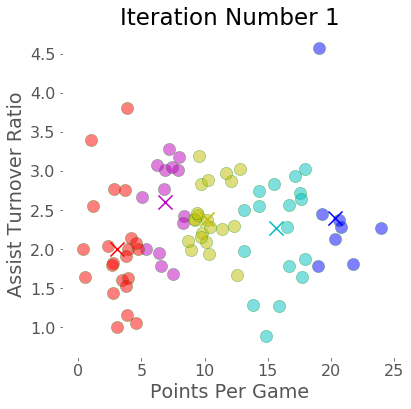

In [91]:
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters, 1)

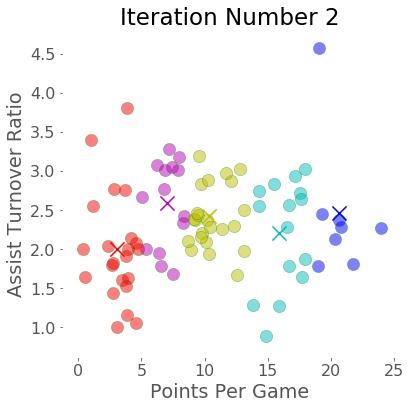

In [92]:
# Iteration 2

centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters, 2)

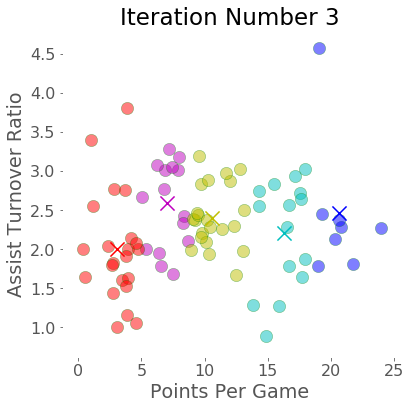

In [93]:
# Iteration 3

centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters, 3)

Note that a few of the points are changing clusters between every iteration (especially in areas where 2 clusters almost overlap), but otherwise, the clusters visually look like they don't move a lot after every iteration. 

K-Means doesn't cause massive changes in the clusters between iterations and converges and becomes stable very fast. **Because K-Means is conservative between iterations, where we pick the initial centroids and how we assign the players to clusters initially matters a lot.**

To counteract these problems, the sklearn implementation of K-Means does some intelligent things like re-running the entire clustering process lots of times with random initial centroids so the final results are a little less biased on one passthrough's initial centroids.

## K-Means Clustering with Scikit Learn


[Here is how the function works](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

```python 
class sklearn.cluster.KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm='auto')
```

n_clusters (default: 8): is the number of clusters to form as well as the number of centroids to generate.
max_iter (default: 300): Maximum number of iterations of the k-means algorithm for a single run.
n_init (default: 10): Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

We can see how this can be a lot more robust than our basic code as it takes multiple initial conditions.

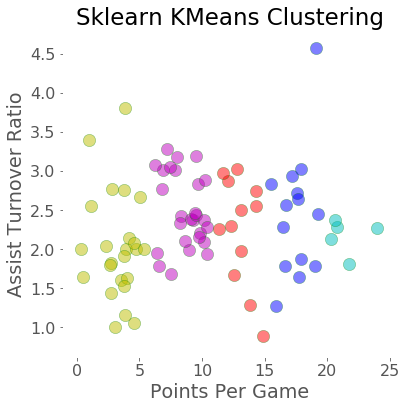

In [99]:
# load the module
from sklearn.cluster import KMeans

# instantiate an instance
kmeans = KMeans(n_clusters=num_clusters, max_iter=100)

# Train the data
kmeans.fit(point_guards[['ppg', 'atr']])

# Store labels of each point in the dataframe
point_guards['cluster'] = kmeans.labels_

# Visualize
colors = ['b', 'y', 'r', 'c', 'y', 'm']

df = point_guards
fig = plt.figure(num=None, figsize=(6, 6), edgecolor='k')
ax = fig.add_subplot(1, 1, 1, facecolor="1.0")
for n in range(num_clusters):
    clustered_df = df[df['cluster'] == n]
    ax.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1], edgecolors='g', alpha=0.5, s=150)
    plt.xlabel('Points Per Game')
    plt.ylabel('Assist Turnover Ratio')
    plt.title('Sklearn KMeans Clustering')
plt.show()

The 4 lines of codes in training a k-means model is extremely powerful and is fairly simple to use. But as a begginer writing the k-means code from scratch was an invaluable lesson for me and helped me understand the nuances of the algorithm. 